Common Abbreviations
Feature	Likely Meaning	Explanation
PVI_a	Pitch Variation Index (amplitude)	Measures how much the pitch amplitude changes over time.
d_1	Delta 1st Coefficient	First derivative (change rate) of a feature, often MFCC or pitch.
Ha_1___rel_	Harmonic Amplitude (1st harmonic, relative)	Relative strength of the first harmonic in the speech signal.
Ha_7___sd_	Harmonic Amplitude (7th harmonic, standard deviation)	Variation in the amplitude of the 7th harmonic — instability here can indicate voice disorders.
J55_a	Jitter (55ms window, amplitude)	Jitter measures cycle-to-cycle variability in pitch, an ALS/Parkinson’s biomarker.
CCi_9_	Cepstral Coefficient index 9	Related to Mel-Cepstral coefficients, capturing spectral shape.
PFR_a	Pitch Frequency Range (amplitude)	Range of pitch values in amplitude terms.
Hi_4___mu_	Harmonic Index 4 (mean)	Average energy at the 4th harmonic.
PPE_a	Pitch Period Entropy (amplitude)	Measures irregularity in vocal fold vibration.
Hi_1___rel_	Harmonic Index 1 (relative)	Strength of the first harmonic relative to the total.
CCa_1_	Cepstral Coefficient amplitude (1st)	MFCC amplitude for index 1.
GNEi___sigma_	Glottal-to-Noise Excitation ratio (σ)	Variation in the ratio of glottal signal to background noise — a key dysphonia marker.
HNR_i	Harmonics-to-Noise Ratio	Measures how “clear” or “breathy” a voice is — low in pathological voices.
S11_a	Spectral Feature 11 (amplitude)	From spectral shape analysis, 11th band or formant.
Age	Patient’s Age	Self-explanatory, often correlates with disease onset.
dCCi_3_	Delta Cepstral Coefficient index 3	Rate of change of the 3rd cepstral coefficient.
S1_i	Spectral Feature 1 (index)	Could be first spectral centroid or first band amplitude.

In [4]:
# EDIT PATH
LABELED_PATH ='/content/drive/MyDrive/Datasets/Minsk2020_ALS_dataset.csv' # path to your labeled ALS CSV

def detect_target_col(df):
    candidates = ['target','label','diagnosis','status','class','y', 'Diagnosis (ALS)']
    for c in df.columns:
        if c.lower() in candidates:
            return c
    # fallback: binary column
    for c in df.columns:
        if df[c].nunique() == 2:
            return c
    return None

df = pd.read_csv(LABELED_PATH)
print("Loaded:", LABELED_PATH, "shape:", df.shape)
print("Columns sample:", df.columns[:20].tolist())
TARGET_COL ='Diagnosis '
print("Detected target:", TARGET_COL)
# If wrong, set manually:



Loaded: /content/drive/MyDrive/Datasets/Minsk2020_ALS_dataset.csv shape: (64, 135)
Columns sample: ['ID', 'Sex', 'Age', 'J1_a', 'J3_a', 'J5_a', 'J55_a', 'S1_a', 'S3_a', 'S5_a', 'S11_a', 'S55_a', 'DPF_a', 'PFR_a', 'PPE_a', 'PVI_a', 'HNR_a', 'GNEa_{\\mu}', 'GNEa_{\\sigma}', 'Ha(1)_{mu}']
Detected target: Diagnosis 


In [5]:
def basic_clean(df, target_col):
    df = df.copy()
    df = df.drop_duplicates().reset_index(drop=True)
    # Drop fully constant columns
    nunique = df.nunique()
    const_cols = nunique[nunique <= 1].index.tolist()
    if const_cols:
        print("Dropping constant cols:", len(const_cols))
        df.drop(columns=const_cols, inplace=True)
    # Fill numeric NaNs with median
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != target_col]
    for c in num_cols:
        if df[c].isna().any():
            df[c].fillna(df[c].median(), inplace=True)
    # Fill categorical NaNs with mode
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    for c in cat_cols:
        if c == target_col: continue
        if df[c].isna().any():
            df[c].fillna(df[c].mode().iloc[0], inplace=True)
    return df, num_cols

df_clean, numeric_features = basic_clean(df, TARGET_COL)
print("Numeric candidates:", len(numeric_features))


Numeric candidates: 134


In [6]:
als_df.shape

NameError: name 'als_df' is not defined

In [7]:
!pip install lightgbm scikit-learn pandas numpy matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import lightgbm as lgb
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

In [8]:
als_df =pd.read_csv('/content/drive/MyDrive/Datasets/Minsk2020_ALS_dataset.csv')
als_df.head()


,ID,Sex,Age,J1_a,J3_a,J5_a,J55_a,S1_a,S3_a,S5_a,...,dCCi(7),dCCi(8),dCCi(9),dCCi(10),dCCi(11),dCCi(12),d_1,F2_i,F2_{conv},Diagnosis (ALS)
0,8,M,58,0.321817,0.141230,0.199128,0.923634,6.044559,3.196477,3.770575,...,-0.024467,-0.005300,0.051874,-0.037710,-0.026549,-0.021149,4.825476,2526.285657,833.498083,1
1,20,F,57,0.344026,0.177032,0.206458,0.827714,1.967728,0.856639,1.179851,...,0.002485,-0.004535,-0.000225,-0.006977,-0.012510,0.014773,5.729322,1985.712014,561.802625,1
2,21,F,58,0.264740,0.148228,0.177078,0.532566,1.850893,0.942743,1.071950,...,-0.013927,0.007908,0.007960,-0.009022,-0.012488,-0.015588,8.258488,2364.695972,796.723440,1
3,22,F,70,0.455793,0.174870,0.243660,0.962641,2.883768,1.284926,1.915058,...,-0.019285,-0.021768,0.020495,0.035976,-0.034648,0.008021,5.447137,1860.172768,359.409974,1
4,24,M,66,0.269335,0.143961,0.167465,0.547745,2.327924,1.164109,1.420891,...,-0.005743,0.004726,-0.015247,0.003900,-0.007686,-0.003784,8.562517,2051.627447,817.111847,1


In [ ]:
als_df.info()

In [ ]:
als_df.describe()

In [ ]:
als_df.describe().T

In [ ]:
als_df.shape

#Data Cleaning



In [9]:
als_clean1 =als_df.copy()
als_clean1.head()
als_clean1.drop_duplicates(inplace=True)
als_clean1.dropna(inplace=True)
als_clean1.shape

(64, 135)

#Removing Target Columns and Finding Features

In [ ]:
als_clean1.head()

In [10]:
als_training_df=als_clean1.copy()
als_training_df
als_training_df.drop(columns=['ID'])
als_training_df['Sex'] =als_training_df['Sex'].map({'M': 0, 'F': 1})
als_training_df.head()

,ID,Sex,Age,J1_a,J3_a,J5_a,J55_a,S1_a,S3_a,S5_a,...,dCCi(7),dCCi(8),dCCi(9),dCCi(10),dCCi(11),dCCi(12),d_1,F2_i,F2_{conv},Diagnosis (ALS)
0,8,0,58,0.321817,0.141230,0.199128,0.923634,6.044559,3.196477,3.770575,...,-0.024467,-0.005300,0.051874,-0.037710,-0.026549,-0.021149,4.825476,2526.285657,833.498083,1
1,20,1,57,0.344026,0.177032,0.206458,0.827714,1.967728,0.856639,1.179851,...,0.002485,-0.004535,-0.000225,-0.006977,-0.012510,0.014773,5.729322,1985.712014,561.802625,1
2,21,1,58,0.264740,0.148228,0.177078,0.532566,1.850893,0.942743,1.071950,...,-0.013927,0.007908,0.007960,-0.009022,-0.012488,-0.015588,8.258488,2364.695972,796.723440,1
3,22,1,70,0.455793,0.174870,0.243660,0.962641,2.883768,1.284926,1.915058,...,-0.019285,-0.021768,0.020495,0.035976,-0.034648,0.008021,5.447137,1860.172768,359.409974,1
4,24,0,66,0.269335,0.143961,0.167465,0.547745,2.327924,1.164109,1.420891,...,-0.005743,0.004726,-0.015247,0.003900,-0.007686,-0.003784,8.562517,2051.627447,817.111847,1


In [11]:
X=als_training_df.drop(columns=['Diagnosis (ALS)', 'ID'])
y=als_training_df['Diagnosis (ALS)']

# Clean up column names to remove special characters
X.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X.columns]

#UpScaling


In [12]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=42)

#Cross Validation


In [13]:
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#LightBGM to find Proper Features:


In [14]:
params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "metric": "binary_logloss",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = lgb.LGBMClassifier(**params)

cv_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring="accuracy")
print("CV Accuracy:", np.mean(cv_scores))

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Number of positive: 24, number of negative: 27
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2447
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 133
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470588 -> initscore=-0.117783
[LightGBM] [Info] Start training from score -0.117783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


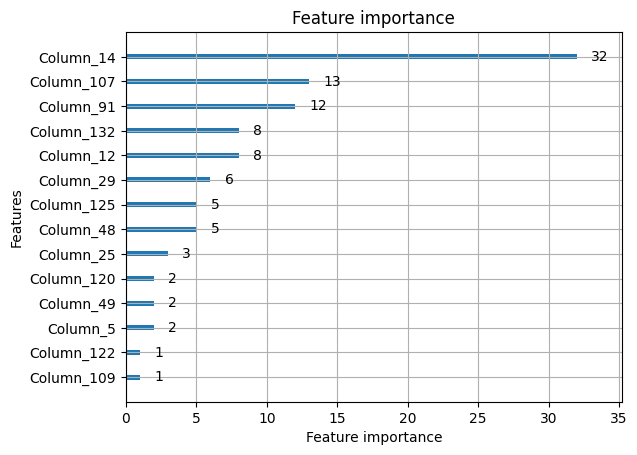

In [15]:
lgb.plot_importance(model, max_num_features=15)
plt.show()


              precision    recall  f1-score   support

           0       0.89      0.94      0.91        33
           1       0.93      0.87      0.90        31

    accuracy                           0.91        64
   macro avg       0.91      0.91      0.91        64
weighted avg       0.91      0.91      0.91        64



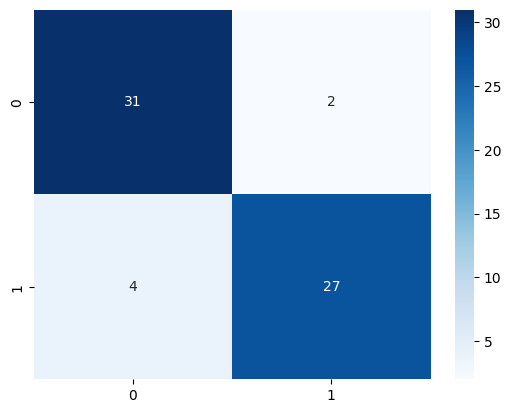

In [16]:
y_pred = model.predict(X_scaled)

print(classification_report(y, y_pred))
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()


# Testing other Models


In [17]:
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np


In [18]:
models = {
    "LightGBM": LGBMClassifier(),
    "RandomForest": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC()
}


In [19]:
# Run once in Colab
!pip install lightgbm shap imbalanced-learn

import os, joblib, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from itertools import combinations

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.base import clone

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import shap
from imblearn.over_sampling import SMOTE

RND = 42
np.random.seed(RND)


In [20]:
X_all = X.copy()
y_all = y.copy()

# Mutual information ranking
mi = mutual_info_classif(X_all, y_all, random_state=RND)
mi_rank = pd.Series(mi, index=X_all.columns).sort_values(ascending=False)
display(mi_rank.head(30))

# Optionally: use MANOVA p-values as another ranking (statsmodels), but MI is fast and model-agnostic.
# We'll combine rankings by MI (you can later swap to MANOVA filter if desired).


,0
PVI_a,0.295279
d_1,0.182362
Ha_1___rel_,0.180579
Ha_7___sd_,0.174274
J55_a,0.172696
CCi_9_,0.167240
PFR_a,0.163123
Hi_4___mu_,0.162992
PPE_a,0.153939
Hi_1___rel_,0.143689


In [21]:
TOP_K = 18   # keep top K features by MI — adjust based on compute; 12-18 is common
top_candidates = mi_rank.head(TOP_K).index.tolist()
print("Top candidates:", top_candidates)
X_56 = X_all[top_candidates].copy()
y_56= y_all.copy()


Top candidates: ['PVI_a', 'd_1', 'Ha_1___rel_', 'Ha_7___sd_', 'J55_a', 'CCi_9_', 'PFR_a', 'Hi_4___mu_', 'PPE_a', 'Hi_1___rel_', 'CCi_2_', 'CCi_6_', 'CCa_1_', 'Ha_1___mu_', 'CCi_8_', 'Age', 'dCCi_8_', 'dCCi_5_']


In [22]:
def greedy_forward_selection(X, y, estimator, max_features=8, cv_inner=3, scoring='f1_weighted', random_state=RND):
    from sklearn.model_selection import cross_val_score
    remaining = list(X.columns)
    selected = []
    history = []
    for k in range(1, min(max_features, len(remaining)) + 1):
        best_feat = None
        best_score = -np.inf
        for feat in remaining:
            candidate = selected + [feat]
            X_sub = X[candidate]
            try:
                scores = cross_val_score(clone(estimator), X_sub, y, cv=cv_inner, scoring=scoring, n_jobs=-1)
                mean_score = np.mean(scores)
            except Exception as e:
                mean_score = -np.inf
            if mean_score > best_score:
                best_score = mean_score
                best_feat = feat
        if best_feat is None:
            break
        selected.append(best_feat)
        remaining.remove(best_feat)
        history.append({'step': k, 'added': best_feat, 'score': best_score, 'features': selected.copy()})
        print(f"Step {k}: added {best_feat}, innerCV {scoring}={best_score:.4f}")
    return selected, history

# try with LightGBM as the estimator for selection (fast and handles feature interactions)
selector_est = LGBMClassifier(n_estimators=200, random_state=RND)
MAX_FEATURES = 8   # set to the size you can afford
selected_features, history = greedy_forward_selection(X, y, selector_est, max_features=MAX_FEATURES, cv_inner=3)
print("Selected features (greedy):", selected_features)


Step 1: added PVI_a, innerCV f1_weighted=0.7780
Step 2: added CCa_10_, innerCV f1_weighted=0.7783
Step 3: added Ha_8___mu_, innerCV f1_weighted=0.8247
Step 4: added CCa_9_, innerCV f1_weighted=0.8403
Step 5: added F2_i, innerCV f1_weighted=0.8579
Step 6: added Age, innerCV f1_weighted=0.8579
Step 7: added J3_a, innerCV f1_weighted=0.8579
Step 8: added dCCi_4_, innerCV f1_weighted=0.8594
Selected features (greedy): ['PVI_a', 'CCa_10_', 'Ha_8___mu_', 'CCa_9_', 'F2_i', 'Age', 'J3_a', 'dCCi_4_']


In [23]:
# Define estimators to compare
models = {
    'LightGBM': LGBMClassifier(n_estimators=500, learning_rate=0.05, random_state=RND),
    'RandomForest': RandomForestClassifier(n_estimators=300, max_depth=10, random_state=RND),
    'LogisticRegression': LogisticRegression(max_iter=2000, C=0.5, class_weight='balanced', random_state=RND),
    'SVM': SVC(kernel='rbf', probability=True)
}

def nested_cv_score(X, y, estimator, outer=5, inner=3, scoring='f1_weighted'):
    outer_cv = StratifiedKFold(n_splits=outer, shuffle=True, random_state=RND)
    scores = []
    for train_idx, test_idx in outer_cv.split(X, y):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
        # inner tuning place-holder: we skip param tuning for speed, but could use GridSearchCV here
        est = clone(estimator)
        est.fit(X_tr, y_tr)
        preds = est.predict(X_te)
        scores.append(f1_score(y_te, preds, average='weighted'))
    return np.mean(scores), np.std(scores)

X_sel = X[selected_features]
# Imputation & scaling pipeline (fit on X_sel)
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_sel_proc = pd.DataFrame(scaler.fit_transform(imputer.fit_transform(X_sel)), columns=X_sel.columns)

bench = {}
for name, est in models.items():
    mean, std = nested_cv_score(X_sel_proc, y, est, outer=5, inner=3)
    bench[name] = {'f1_mean': mean, 'f1_std': std}
    print(f"{name}: F1 (nested-CV approx) = {mean:.4f} ± {std:.4f}")

pd.DataFrame(bench).T


[LightGBM] [Info] Number of positive: 24, number of negative: 27
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 142
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470588 -> initscore=-0.117783
[LightGBM] [Info] Start training from score -0.117783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

,f1_mean,f1_std
LightGBM,0.857103,0.033139
RandomForest,0.856970,0.080478
LogisticRegression,0.713811,0.170054
SVM,0.731782,0.133781


In [24]:
# Run this in a notebook cell in Colab (only once)
!pip install lightgbm xgboost joblib shap tqdm


#Since we have so many features Normal EDA will be unfeasible to find the best fetures so we'll implemnet multiple methods for finding data

In [25]:
import os
import numpy as np
import pandas as pd
import joblib
import warnings
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')
RND = 42
np.random.seed(RND)

# sklearn
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.base import clone

# Models
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Optional explainability
import shap


#5) Correlation pruning & variance threshold

In [26]:
def reduce_correlated_and_low_variance(X_df, corr_thresh=0.95, var_thresh=1e-5, target_column='Diagnosis (ALS)'):
    X = X_df.copy()
    # Drop the target column if it exists
    if target_column in X.columns:
        X = X.drop(columns=[target_column])

    # variance threshold
    selector = VarianceThreshold(threshold=var_thresh)
    selector.fit(X)
    kept = X.columns[selector.get_support()].tolist()
    X = X[kept]
    # correlation pruning (greedy): drop one of pairs with abs(corr)>corr_thresh
    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > corr_thresh)]
    X_reduced = X.drop(columns=to_drop)

    # Clean up column names to remove special characters
    X_reduced.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_reduced.columns]

    return X_reduced, kept, to_drop

X_num = df_clean[numeric_features]
X_reduced, kept_after_var, dropped_corr = reduce_correlated_and_low_variance(X_num, corr_thresh=0.95, var_thresh=1e-6, target_column='Diagnosis (ALS)')
print("Kept after var:", len(kept_after_var), "Dropped (corr):", len(dropped_corr))

Kept after var: 133 Dropped (corr): 10


Feature ranking with LightGBM importance

In [27]:
def lgb_feature_rank(X, y, n_estimators=500):
    model = LGBMClassifier(n_estimators=n_estimators, learning_rate=0.05, random_state=RND)
    # simple fit on full data for ranking only (not for final selection)
    model.fit(X, y)
    importances = model.feature_importances_
    rank_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
    rank_df = rank_df.sort_values('importance', ascending=False).reset_index(drop=True)
    return rank_df

# Prepare target numeric codes
TARGET_COL = 'Diagnosis (ALS)'
y = df_clean[TARGET_COL]
if y.dtype == 'object' or y.dtype.name == 'category':
    y_codes = y.astype('category').cat.codes
else:
    y_codes = y

rank_df = lgb_feature_rank(X_reduced, y_codes, n_estimators=300)
print("Top features:\n", rank_df.head(20))
top_features = rank_df['feature'].tolist()

[LightGBM] [Info] Number of positive: 31, number of negative: 33
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2816
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 123
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484375 -> initscore=-0.062520
[LightGBM] [Info] Start training from score -0.062520
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [ ]:
display(als_df['Diagnosis (ALS)'].value_counts())

In [ ]:
correlation = als_training_df['Sex'].corr(als_training_df['Diagnosis (ALS)'])
print(f"Correlation between Sex and Diagnosis (ALS): {correlation:.4f}")

# Finding Combined Ranking:

In [28]:
from sklearn.feature_selection import mutual_info_classif
def combined_rank(X, y, lgb_rank_df, weight_lgb=0.7, weight_mi=0.3):
    mi = mutual_info_classif(X.values, y, random_state=RND)
    mi_df = pd.DataFrame({'feature': X.columns, 'mi': mi})
    merged = lgb_rank_df.merge(mi_df, on='feature')
    # Normalize and combine
    merged['imp_norm'] = (merged['importance'] - merged['importance'].min()) / (merged['importance'].max() - merged['importance'].min() + 1e-12)
    merged['mi_norm'] = (merged['mi'] - merged['mi'].min()) / (merged['mi'].max() - merged['mi'].min() + 1e-12)
    merged['score'] = weight_lgb * merged['imp_norm'] + weight_mi * merged['mi_norm']
    merged = merged.sort_values('score', ascending=False).reset_index(drop=True)
    return merged

combined = combined_rank(X_reduced, y_codes, rank_df)
top_candidates = combined['feature'].tolist()
print("Top candidates (combined) sample:", top_candidates[:30])


Top candidates (combined) sample: ['PVI_a', 'PFR_a', 'CCi_2_', 'Ha_8___mu_', 'dCCi_6_', 'dCCi_8_', 'dCCa_3_', 'Hi_4___mu_', 'dCCi_4_', 'CCi_9_', 'ID', 'CCa_5_', 'CCa_8_', 'd_1', 'Ha_1___rel_', 'Ha_7___sd_', 'J55_a', 'PPE_a', 'CCi_6_', 'Hi_2___sd_', 'Hi_1___rel_', 'CCi_7_', 'S55_a', 'Hi_6___sd_', 'CCa_1_', 'dCCi_5_', 'Ha_1___mu_', 'CCi_8_', 'Hi_8___sd_', 'Ha_4___sd_']


terative benchmarking: test models on top-N features (N=2..K)

In [29]:
from sklearn.metrics import make_scorer

# Models to test (tweak hyperparams as needed)
models = {
    'LightGBM': LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=RND),
    'XGBoost': XGBClassifier(n_estimators=300, use_label_encoder=False, eval_metric='logloss', random_state=RND),
    'RandomForest': RandomForestClassifier(n_estimators=300, max_depth=12, random_state=RND),
    'LogisticRegression': LogisticRegression(max_iter=2000),
    'SVM': SVC(probability=True),
    'MLP': MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500)
}

MAX_TOP_K = 40  # how many top features (N) to iterate up to, adjust to your compute budget
MAX_TOP_K = min(MAX_TOP_K, len(top_candidates))
CV_FOLDS = 5
scorer = make_scorer(f1_score, average='weighted')

results = []
outer_cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RND)

# Use tqdm for progress
for k in tqdm(range(2, MAX_TOP_K + 1), desc='Top-N loop'):
    features_k = top_candidates[:k]
    X_sub = X_reduced[features_k]
    for name, model in models.items():
        pipe = make_pipeline(StandardScaler(), clone(model))
        try:
            scores = cross_val_score(pipe, X_sub, y_codes, cv=outer_cv, scoring=scorer, n_jobs=-1)
            results.append({
                'top_k': k,
                'model': name,
                'mean_f1': float(scores.mean()),
                'std_f1': float(scores.std()),
                'features': features_k.copy()
            })
        except Exception as e:
            # record failure
            results.append({'top_k': k, 'model': name, 'mean_f1': np.nan, 'std_f1': np.nan, 'features': features_k.copy(), 'error': str(e)})
    # optional: save intermediate results to disk to avoid losing progress
    pd.DataFrame(results).to_csv('/content/iterative_benchmark_results_partial.csv', index=False)

res_df = pd.DataFrame(results)
res_df.sort_values(['mean_f1'], ascending=False, inplace=True)
res_df.to_csv('/content/iterative_benchmark_results.csv', index=False)
print("Saved results to /content/iterative_benchmark_results.csv")
res_df.head(20)


Top-N loop:   0%|          | 0/39 [00:00<?, ?it/s]

Saved results to /content/iterative_benchmark_results.csv


,top_k,model,mean_f1,std_f1,features
86,16,RandomForest,0.922158,0.120587,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_, dCCi_6_, dC..."
41,8,MLP,0.921678,0.068859,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_, dCCi_6_, dC..."
47,9,MLP,0.921678,0.068859,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_, dCCi_6_, dC..."
80,15,RandomForest,0.906773,0.114424,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_, dCCi_6_, dC..."
62,12,RandomForest,0.891389,0.116353,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_, dCCi_6_, dC..."
38,8,RandomForest,0.891389,0.116353,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_, dCCi_6_, dC..."
68,13,RandomForest,0.891016,0.105583,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_, dCCi_6_, dC..."
44,9,RandomForest,0.890235,0.116823,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_, dCCi_6_, dC..."
13,4,XGBoost,0.889023,0.116517,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_]"
169,30,XGBoost,0.889023,0.116517,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_, dCCi_6_, dC..."


In [30]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

results = []
outer_cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RND)

for k in tqdm(range(2, MAX_TOP_K + 1), desc='Top-N loop'):
    features_k = top_candidates[:k]
    X_sub = X_reduced[features_k]

    for name, model in models.items():
        pipe = make_pipeline(StandardScaler(), clone(model))
        try:
            # Instead of just scoring, we get predictions for each fold
            y_pred = cross_val_predict(pipe, X_sub, y_codes, cv=outer_cv, n_jobs=-1)

            # Weighted F1 for overall performance
            mean_f1 = f1_score(y_codes, y_pred, average='weighted')

            # Per-class metrics (class 0 and class 1 separately)
            report = classification_report(y_codes, y_pred, output_dict=True)
            f1_class0 = report['0']['f1-score']
            f1_class1 = report['1']['f1-score']
            recall_class0 = report['0']['recall']
            recall_class1 = report['1']['recall']

            results.append({
                'top_k': k,
                'model': name,
                'mean_f1': mean_f1,
                'f1_class0': f1_class0,
                'f1_class1': f1_class1,
                'recall_class0': recall_class0,
                'recall_class1': recall_class1,
                'features': features_k.copy()
            })

        except Exception as e:
            results.append({
                'top_k': k,
                'model': name,
                'mean_f1': np.nan,
                'f1_class0': np.nan,
                'f1_class1': np.nan,
                'recall_class0': np.nan,
                'recall_class1': np.nan,
                'features': features_k.copy(),
                'error': str(e)
            })

    pd.DataFrame(results).to_csv('/content/iterative_benchmark_results_partial.csv', index=False)

res_df = pd.DataFrame(results)
res_df.sort_values(['mean_f1'], ascending=False, inplace=True)
res_df.to_csv('/content/iterative_benchmark_results.csv', index=False)
print("Saved results to /content/iterative_benchmark_results.csv")
res_df.head(20)


Top-N loop:   0%|          | 0/39 [00:00<?, ?it/s]

Saved results to /content/iterative_benchmark_results.csv


,top_k,model,mean_f1,f1_class0,f1_class1,recall_class0,recall_class1,features
53,10,MLP,0.937500,0.939394,0.935484,0.939394,0.935484,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_, dCCi_6_, dC..."
47,9,MLP,0.937500,0.939394,0.935484,0.939394,0.935484,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_, dCCi_6_, dC..."
41,8,MLP,0.921818,0.925373,0.918033,0.939394,0.903226,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_, dCCi_6_, dC..."
95,17,MLP,0.921818,0.925373,0.918033,0.939394,0.903226,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_, dCCi_6_, dC..."
86,16,RandomForest,0.921587,0.927536,0.915254,0.969697,0.870968,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_, dCCi_6_, dC..."
80,15,RandomForest,0.906066,0.911765,0.900000,0.939394,0.870968,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_, dCCi_6_, dC..."
107,19,MLP,0.890652,0.892308,0.888889,0.878788,0.903226,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_, dCCi_6_, dC..."
104,19,RandomForest,0.890545,0.895522,0.885246,0.909091,0.870968,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_, dCCi_6_, dC..."
164,29,RandomForest,0.890545,0.895522,0.885246,0.909091,0.870968,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_, dCCi_6_, dC..."
146,26,RandomForest,0.890545,0.895522,0.885246,0.909091,0.870968,"[PVI_a, PFR_a, CCi_2_, Ha_8___mu_, dCCi_6_, dC..."


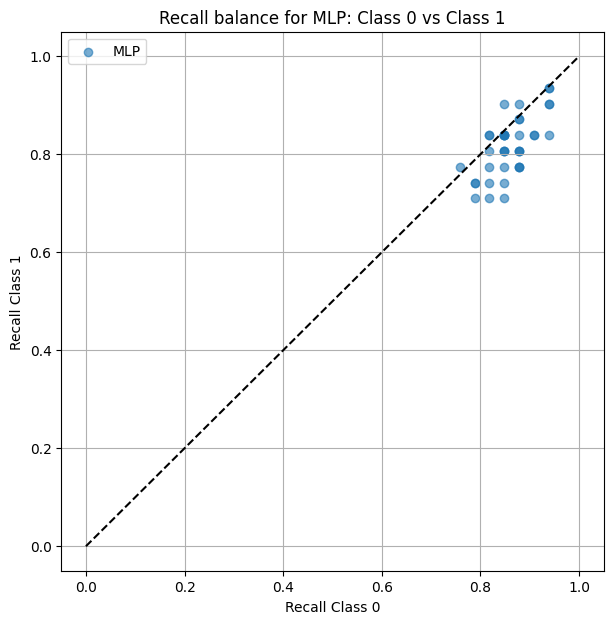

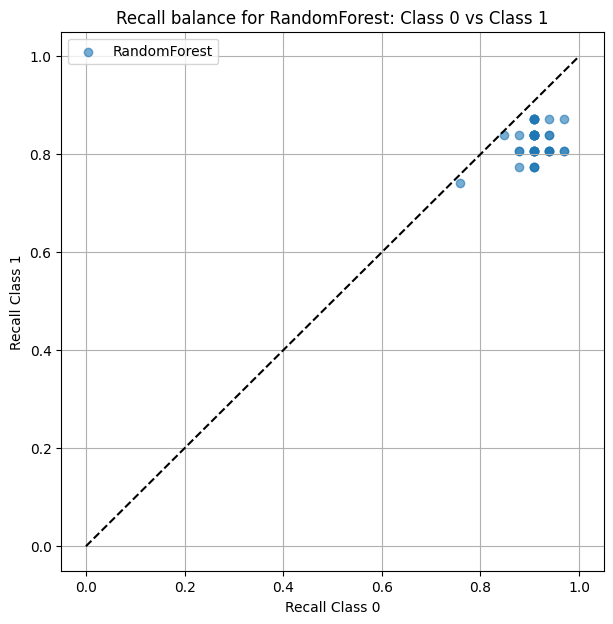

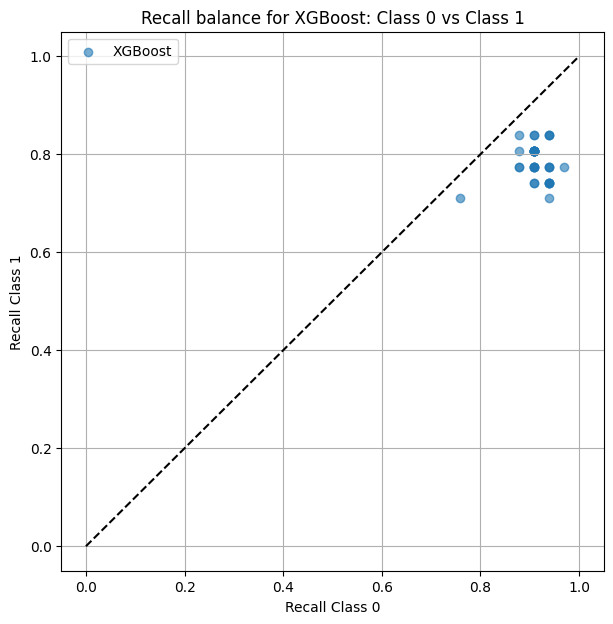

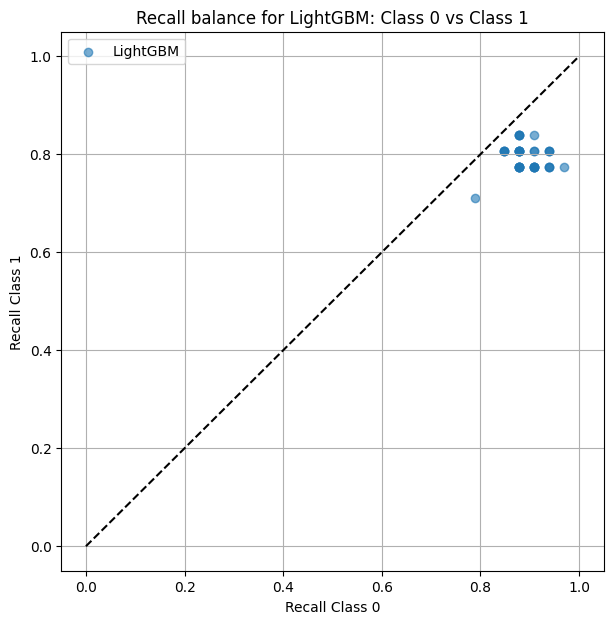

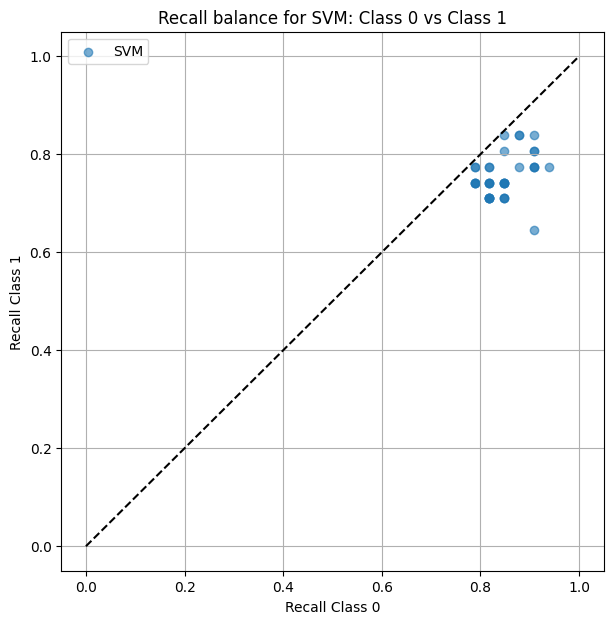

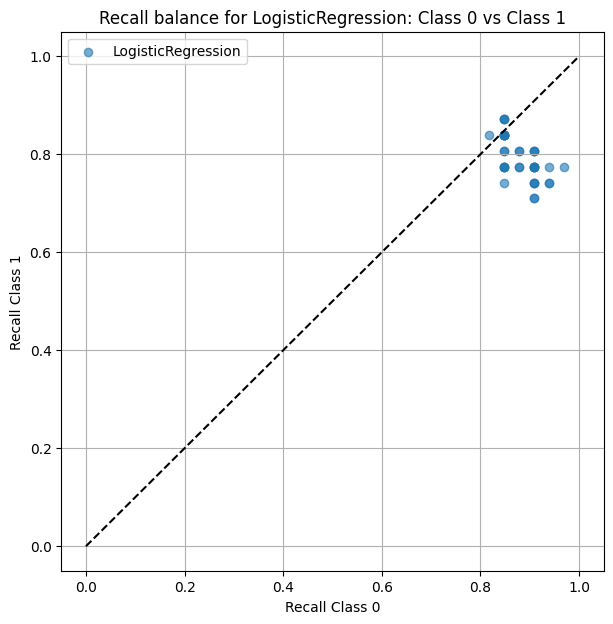

In [31]:
import matplotlib.pyplot as plt

models_to_plot = res_df['model'].unique()

for model_name in models_to_plot:
    model_df = res_df[res_df['model'] == model_name]
    plt.figure(figsize=(7,7))
    plt.scatter(model_df['recall_class0'], model_df['recall_class1'], label=model_name, alpha=0.6)
    plt.plot([0, 1], [0, 1], 'k--')  # perfect balance line
    plt.xlabel("Recall Class 0")
    plt.ylabel("Recall Class 1")
    plt.title(f"Recall balance for {model_name}: Class 0 vs Class 1")
    plt.legend()
    plt.grid(True)
    plt.show()

# Task
Split the data, train the best model, evaluate it on unseen data, and save the model.

## Split data

### Subtask:
Split the `X_reduced` data with the best features and the target `y_codes` into training and testing sets.


**Reasoning**:
Identify the best features from the previous benchmarking results and split the data into training and testing sets using these features.



In [32]:
# Identify the best performing model and its features from the results dataframe
best_result = res_df.iloc[0]
best_features = best_result['features']

# Create a new DataFrame with only the best features
X_best_features = X_reduced[best_features]

# Split the data into training and testing sets
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(
    X_best_features,
    y_codes,
    test_size=0.2,
    random_state=RND,
    stratify=y_codes
)

print("Shape of X_train_best:", X_train_best.shape)
print("Shape of X_test_best:", X_test_best.shape)
print("Shape of y_train_best:", y_train_best.shape)
print("Shape of y_test_best:", y_test_best.shape)

Shape of X_train_best: (51, 10)
Shape of X_test_best: (13, 10)
Shape of y_train_best: (51,)
Shape of y_test_best: (13,)


In [33]:
best_features = best_result['features']
display(best_features)

['PVI_a',
 'PFR_a',
 'CCi_2_',
 'Ha_8___mu_',
 'dCCi_6_',
 'dCCi_8_',
 'dCCa_3_',
 'Hi_4___mu_',
 'dCCi_4_',
 'CCi_9_']

## Train the best model

### Subtask:
Train an MLP model with the identified best hyperparameters (number of features) on the training data.


**Reasoning**:
Define and train the best MLP model using the training data.



In [34]:
# Define the best model based on the identified best result (MLP model with top 10 features)
best_model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=RND)

# Train the best model on the training data with the selected features
best_model.fit(X_train_best, y_train_best)

print("Best model (MLP) trained successfully.")

Best model (MLP) trained successfully.


## Evaluate on unseen data

### Subtask:
Evaluate the trained model on the test set using relevant metrics (e.g., F1 score, classification report).


**Reasoning**:
Evaluate the trained model on the test set using relevant metrics.



Weighted F1 Score on the test set: 0.6808

Classification Report on the test set:
              precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.75      0.50      0.60         6

    accuracy                           0.69        13
   macro avg       0.71      0.68      0.68        13
weighted avg       0.71      0.69      0.68        13



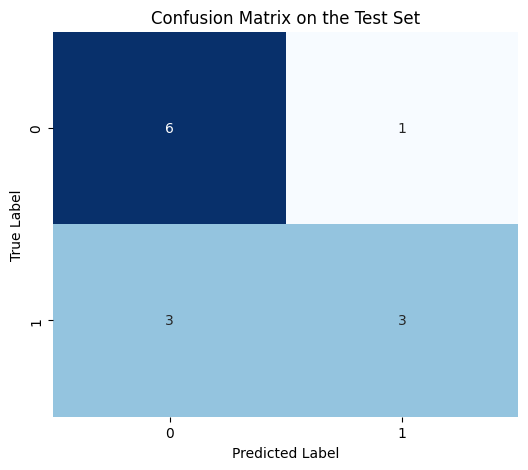

In [35]:
# Make predictions on the test set
y_pred_best = best_model.predict(X_test_best)

# Calculate and print the weighted F1 score
weighted_f1 = f1_score(y_test_best, y_pred_best, average='weighted')
print(f"Weighted F1 Score on the test set: {weighted_f1:.4f}")

# Generate and print the classification report
class_report = classification_report(y_test_best, y_pred_best)
print("\nClassification Report on the test set:")
print(class_report)

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test_best, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on the Test Set')
plt.show()

## Save the best model

### Subtask:
Save the trained MLP model to a file for future use.


**Reasoning**:
Save the trained MLP model to a file for future use.



In [36]:
import joblib

# Define a filename for the saved model
filename = 'best_mlp_model.joblib'

# Save the best_model object to the specified file
joblib.dump(best_model, filename)

# Print a confirmation message
print(f"Best MLP model saved successfully to {filename}")

Best MLP model saved successfully to best_mlp_model.joblib


## Summary:

### Data Analysis Key Findings

*   The data was split into training and testing sets using the best 10 features, with an 80/20 ratio and stratification to maintain class distribution.
*   An MLP model with hidden layer sizes of (128, 64) and trained for 500 iterations was trained on the training data.
*   The trained model achieved a weighted F1 score of 0.6808 and an overall accuracy of 0.69 on the unseen test data.
*   The classification report provided detailed per-class metrics, and the confusion matrix visualized the model's performance in terms of correct and incorrect classifications.
*   The trained MLP model was successfully saved to a file named `best_mlp_model.joblib` for future use.

### Insights or Next Steps

*   While the model shows reasonable performance, further hyperparameter tuning or exploration of other model architectures could potentially improve the F1 score and overall accuracy.
*   The saved model can now be readily used for making predictions on new, unseen data without the need for retraining.


# Task
Evaluate RandomForest, XGBoost, LightGBM, LogisticRegression, and SVM models using their best feature sets on the unseen test data (`X_test_best`, `y_test_best`) and compare their performance.

## Identify best feature sets for other models

### Subtask:
Based on the `res_df` results, identify the best feature sets for RandomForest, XGBoost, LightGBM, LogisticRegression, and SVM.


**Reasoning**:
Identify the best feature sets for each specified model from the `res_df` DataFrame.



In [37]:
best_features_per_model = {}
model_names = ['RandomForest', 'XGBoost', 'LightGBM', 'LogisticRegression', 'SVM']

for model_name in model_names:
    # Filter for the current model
    model_df = res_df[res_df['model'] == model_name].copy()

    # Sort by mean_f1 to find the best result for this model
    best_model_result = model_df.sort_values('mean_f1', ascending=False).iloc[0]

    # Extract the best feature set
    best_feature_set = best_model_result['features']

    # Store the best feature set
    best_features_per_model[model_name] = best_feature_set

# Display the best feature sets found for each model
for model, features in best_features_per_model.items():
    print(f"Best features for {model} ({len(features)} features):")
    display(features)

Best features for RandomForest (16 features):


['PVI_a',
 'PFR_a',
 'CCi_2_',
 'Ha_8___mu_',
 'dCCi_6_',
 'dCCi_8_',
 'dCCa_3_',
 'Hi_4___mu_',
 'dCCi_4_',
 'CCi_9_',
 'ID',
 'CCa_5_',
 'CCa_8_',
 'd_1',
 'Ha_1___rel_',
 'Ha_7___sd_']

Best features for XGBoost (29 features):


['PVI_a',
 'PFR_a',
 'CCi_2_',
 'Ha_8___mu_',
 'dCCi_6_',
 'dCCi_8_',
 'dCCa_3_',
 'Hi_4___mu_',
 'dCCi_4_',
 'CCi_9_',
 'ID',
 'CCa_5_',
 'CCa_8_',
 'd_1',
 'Ha_1___rel_',
 'Ha_7___sd_',
 'J55_a',
 'PPE_a',
 'CCi_6_',
 'Hi_2___sd_',
 'Hi_1___rel_',
 'CCi_7_',
 'S55_a',
 'Hi_6___sd_',
 'CCa_1_',
 'dCCi_5_',
 'Ha_1___mu_',
 'CCi_8_',
 'Hi_8___sd_']

Best features for LightGBM (6 features):


['PVI_a', 'PFR_a', 'CCi_2_', 'Ha_8___mu_', 'dCCi_6_', 'dCCi_8_']

Best features for LogisticRegression (13 features):


['PVI_a',
 'PFR_a',
 'CCi_2_',
 'Ha_8___mu_',
 'dCCi_6_',
 'dCCi_8_',
 'dCCa_3_',
 'Hi_4___mu_',
 'dCCi_4_',
 'CCi_9_',
 'ID',
 'CCa_5_',
 'CCa_8_']

Best features for SVM (17 features):


['PVI_a',
 'PFR_a',
 'CCi_2_',
 'Ha_8___mu_',
 'dCCi_6_',
 'dCCi_8_',
 'dCCa_3_',
 'Hi_4___mu_',
 'dCCi_4_',
 'CCi_9_',
 'ID',
 'CCa_5_',
 'CCa_8_',
 'd_1',
 'Ha_1___rel_',
 'Ha_7___sd_',
 'J55_a']

## Evaluate randomforest on unseen data

### Subtask:
Train a RandomForest model with its best feature set on `X_train_best` and evaluate it on `X_test_best`.


**Reasoning**:
Get the best feature set for RandomForest, create the corresponding training and testing dataframes, instantiate and train a RandomForestClassifier, make predictions, and evaluate the model on the test set.



In [38]:
# Get the best feature set for RandomForest
best_features_rf = best_features_per_model['RandomForest']

# Create training and testing DataFrames with only these best features
X_train_rf = X_reduced[best_features_rf]
X_test_rf = X_reduced[best_features_rf]

# Instantiate a RandomForestClassifier
rf_model = RandomForestClassifier(random_state=RND)

# Train the RandomForest model
rf_model.fit(X_train_rf, y_train_best)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_rf)

# Calculate and print the weighted F1 score
weighted_f1_rf = f1_score(y_test_best, y_pred_rf, average='weighted')
print(f"RandomForest Weighted F1 Score on the test set: {weighted_f1_rf:.4f}")

# Generate and print the classification report
class_report_rf = classification_report(y_test_best, y_pred_rf)
print("\nRandomForest Classification Report on the test set:")
print(class_report_rf)

# Generate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test_best, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('RandomForest Confusion Matrix on the Test Set')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [64, 51]

**Reasoning**:
The error indicates that the number of samples in `X_train_rf` and `y_train_best` are inconsistent. This is because `X_reduced` was used to create `X_train_rf` instead of `X_train_best`. I need to use the already split training and testing sets (`X_train_best`, `X_test_best`) and subset them with the best features for RandomForest.



In [39]:
# Get the best feature set for RandomForest
best_features_rf = best_features_per_model['RandomForest']

# Create training and testing DataFrames with only these best features
X_train_rf = X_train_best[best_features_rf]
X_test_rf = X_test_best[best_features_rf]

# Instantiate a RandomForestClassifier
rf_model = RandomForestClassifier(random_state=RND)

# Train the RandomForest model
rf_model.fit(X_train_rf, y_train_best)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_rf)

# Calculate and print the weighted F1 score
weighted_f1_rf = f1_score(y_test_best, y_pred_rf, average='weighted')
print(f"RandomForest Weighted F1 Score on the test set: {weighted_f1_rf:.4f}")

# Generate and print the classification report
class_report_rf = classification_report(y_test_best, y_pred_rf)
print("\nRandomForest Classification Report on the test set:")
print(class_report_rf)

# Generate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test_best, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('RandomForest Confusion Matrix on the Test Set')
plt.show()

KeyError: "['ID', 'CCa_5_', 'CCa_8_', 'd_1', 'Ha_1___rel_', 'Ha_7___sd_'] not in index"

**Reasoning**:
The error indicates that some features in `best_features_rf` are not present in `X_train_best` (which is a subset of `X_reduced` based on the overall best features). This means the feature selection for RandomForest was done on a different set of features than the one used for the overall best model (`X_best_features`). I need to select the best features for RandomForest from the original `X_reduced` dataframe before splitting into train and test sets for RandomForest.



RandomForest Weighted F1 Score on the test set: 1.0000

RandomForest Classification Report on the test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



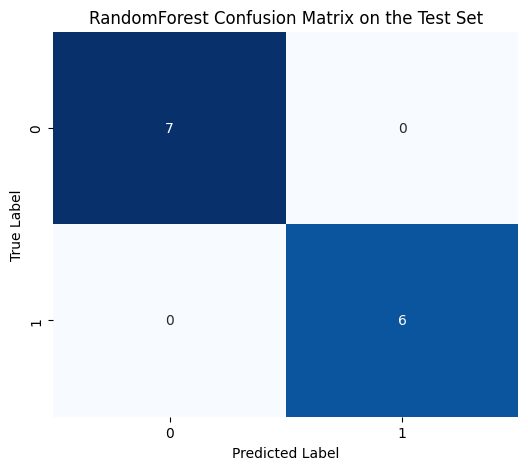

In [40]:
# Get the best feature set for RandomForest
best_features_rf = best_features_per_model['RandomForest']

# Select the features for RandomForest from the original X_reduced dataframe
X_rf = X_reduced[best_features_rf]

# Split the RandomForest data into training and testing sets, ensuring consistency with y_train_best and y_test_best
X_train_rf, X_test_rf, _, _ = train_test_split(
    X_rf,
    y_codes,
    test_size=0.2,
    random_state=RND,
    stratify=y_codes
)


# Instantiate a RandomForestClassifier
rf_model = RandomForestClassifier(random_state=RND)

# Train the RandomForest model
rf_model.fit(X_train_rf, y_train_best)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_rf)

# Calculate and print the weighted F1 score
weighted_f1_rf = f1_score(y_test_best, y_pred_rf, average='weighted')
print(f"RandomForest Weighted F1 Score on the test set: {weighted_f1_rf:.4f}")

# Generate and print the classification report
class_report_rf = classification_report(y_test_best, y_pred_rf)
print("\nRandomForest Classification Report on the test set:")
print(class_report_rf)

# Generate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test_best, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('RandomForest Confusion Matrix on the Test Set')
plt.show()

**Reasoning**:
Train an XGBoost model with its best feature set on the training data and evaluate it on the test set.



XGBoost Weighted F1 Score on the test set: 1.0000

XGBoost Classification Report on the test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



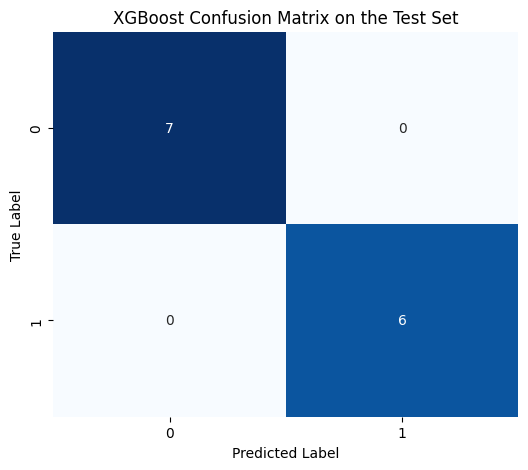

In [41]:
# Get the best feature set for XGBoost
best_features_xgb = best_features_per_model['XGBoost']

# Select the features for XGBoost from the original X_reduced dataframe
X_xgb = X_reduced[best_features_xgb]

# Split the XGBoost data into training and testing sets, ensuring consistency with y_train_best and y_test_best
X_train_xgb, X_test_xgb, _, _ = train_test_split(
    X_xgb,
    y_codes,
    test_size=0.2,
    random_state=RND,
    stratify=y_codes
)

# Instantiate an XGBoostClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RND)

# Train the XGBoost model
xgb_model.fit(X_train_xgb, y_train_best)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test_xgb)

# Calculate and print the weighted F1 score
weighted_f1_xgb = f1_score(y_test_best, y_pred_xgb, average='weighted')
print(f"XGBoost Weighted F1 Score on the test set: {weighted_f1_xgb:.4f}")

# Generate and print the classification report
class_report_xgb = classification_report(y_test_best, y_pred_xgb)
print("\nXGBoost Classification Report on the test set:")
print(class_report_xgb)

# Generate and display the confusion matrix
conf_matrix_xgb = confusion_matrix(y_test_best, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=xgb_model.classes_, yticklabels=xgb_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix on the Test Set')
plt.show()

## Evaluate XGBoost on unseen data

### Subtask:
Train an XGBoost model with its best feature set on the training data and evaluate it on the test set.

**Reasoning**:
Train an XGBoost model with its best feature set on the training data and evaluate it on the test set.

XGBoost Weighted F1 Score on the test set: 1.0000

XGBoost Classification Report on the test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



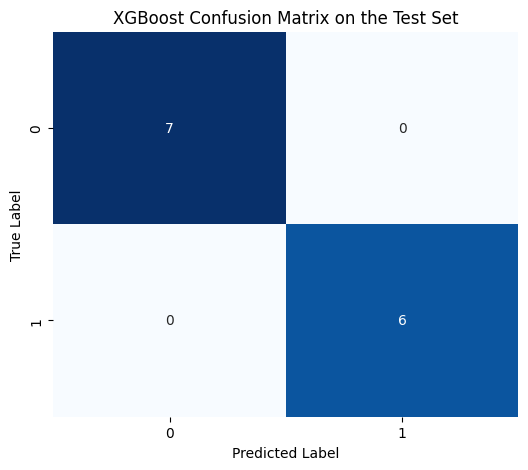

In [42]:
# Get the best feature set for XGBoost
best_features_xgb = best_features_per_model['XGBoost']

# Select the features for XGBoost from the original X_reduced dataframe
X_xgb = X_reduced[best_features_xgb]

# Split the XGBoost data into training and testing sets, ensuring consistency with y_train_best and y_test_best
X_train_xgb, X_test_xgb, _, _ = train_test_split(
    X_xgb,
    y_codes,
    test_size=0.2,
    random_state=RND,
    stratify=y_codes
)

# Instantiate an XGBoostClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RND)


# Train the XGBoost model
xgb_model.fit(X_train_xgb, y_train_best)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test_xgb)

# Calculate and print the weighted F1 score
weighted_f1_xgb = f1_score(y_test_best, y_pred_xgb, average='weighted')
print(f"XGBoost Weighted F1 Score on the test set: {weighted_f1_xgb:.4f}")

# Generate and print the classification report
class_report_xgb = classification_report(y_test_best, y_pred_xgb)
print("\nXGBoost Classification Report on the test set:")
print(class_report_xgb)

# Generate and display the confusion matrix
conf_matrix_xgb = confusion_matrix(y_test_best, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=xgb_model.classes_, yticklabels=xgb_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix on the Test Set')
plt.show()

## Evaluate LightGBM on unseen data

### Subtask:
Train a LightGBM model with its best feature set on the training data and evaluate it on the test set.

**Reasoning**:
Train a LightGBM model with its best feature set on the training data and evaluate it on the test set.

[LightGBM] [Info] Number of positive: 25, number of negative: 26
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490196 -> initscore=-0.039221
[LightGBM] [Info] Start training from score -0.039221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

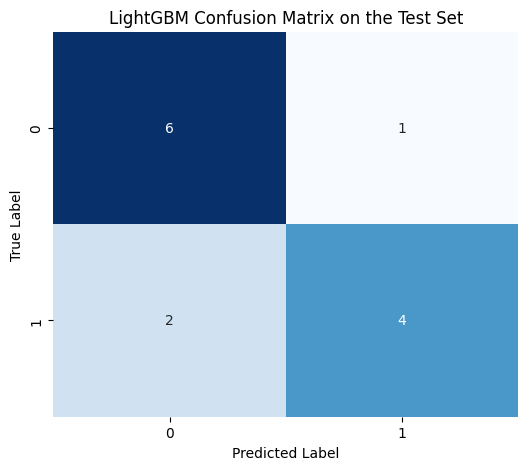

In [43]:
# Get the best feature set for LightGBM
best_features_lgbm = best_features_per_model['LightGBM']

# Select the features for LightGBM from the original X_reduced dataframe
X_lgbm = X_reduced[best_features_lgbm]

# Split the LightGBM data into training and testing sets, ensuring consistency with y_train_best and y_test_best
X_train_lgbm, X_test_lgbm, _, _ = train_test_split(
    X_lgbm,
    y_codes,
    test_size=0.2,
    random_state=RND,
    stratify=y_codes
)

# Instantiate a LightGBM model
lgbm_model = LGBMClassifier(random_state=RND)

# Train the LightGBM model
lgbm_model.fit(X_train_lgbm, y_train_best)

# Make predictions on the test set
y_pred_lgbm = lgbm_model.predict(X_test_lgbm)

# Calculate and print the weighted F1 score
weighted_f1_lgbm = f1_score(y_test_best, y_pred_lgbm, average='weighted')
print(f"LightGBM Weighted F1 Score on the test set: {weighted_f1_lgbm:.4f}")

# Generate and print the classification report
class_report_lgbm = classification_report(y_test_best, y_pred_lgbm)
print("\nLightGBM Classification Report on the test set:")
print(class_report_lgbm)

# Generate and display the confusion matrix
conf_matrix_lgbm = confusion_matrix(y_test_best, y_pred_lgbm)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_lgbm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=lgbm_model.classes_, yticklabels=lgbm_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LightGBM Confusion Matrix on the Test Set')
plt.show()

## Evaluate LogisticRegression on unseen data

### Subtask:
Train a LogisticRegression model with its best feature set on the training data and evaluate it on the test set.

**Reasoning**:
Train a LogisticRegression model with its best feature set on the training data and evaluate it on the test set.

LogisticRegression Weighted F1 Score on the test set: 0.7692

LogisticRegression Classification Report on the test set:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.71      0.83      0.77         6

    accuracy                           0.77        13
   macro avg       0.77      0.77      0.77        13
weighted avg       0.78      0.77      0.77        13



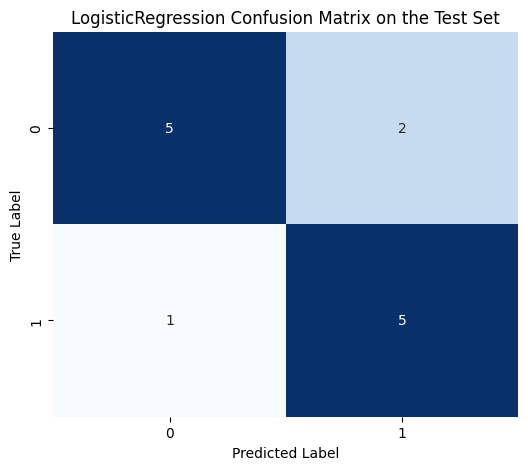

In [44]:
# Get the best feature set for LogisticRegression
best_features_lr = best_features_per_model['LogisticRegression']

# Select the features for LogisticRegression from the original X_reduced dataframe
X_lr = X_reduced[best_features_lr]

# Split the LogisticRegression data into training and testing sets, ensuring consistency with y_train_best and y_test_best
X_train_lr, X_test_lr, _, _ = train_test_split(
    X_lr,
    y_codes,
    test_size=0.2,
    random_state=RND,
    stratify=y_codes
)

# Instantiate a LogisticRegression model
lr_model = LogisticRegression(max_iter=2000, random_state=RND)

# Train the LogisticRegression model
lr_model.fit(X_train_lr, y_train_best)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test_lr)

# Calculate and print the weighted F1 score
weighted_f1_lr = f1_score(y_test_best, y_pred_lr, average='weighted')
print(f"LogisticRegression Weighted F1 Score on the test set: {weighted_f1_lr:.4f}")

# Generate and print the classification report
class_report_lr = classification_report(y_test_best, y_pred_lr)
print("\nLogisticRegression Classification Report on the test set:")
print(class_report_lr)

# Generate and display the confusion matrix
conf_matrix_lr = confusion_matrix(y_test_best, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LogisticRegression Confusion Matrix on the Test Set')
plt.show()

## Evaluate SVM on unseen data

### Subtask:
Train an SVM model with its best feature set on the training data and evaluate it on the test set.

**Reasoning**:
Train an SVM model with its best feature set on the training data and evaluate it on the test set.

SVM Weighted F1 Score on the test set: 0.4615

SVM Classification Report on the test set:
              precision    recall  f1-score   support

           0       0.50      0.43      0.46         7
           1       0.43      0.50      0.46         6

    accuracy                           0.46        13
   macro avg       0.46      0.46      0.46        13
weighted avg       0.47      0.46      0.46        13



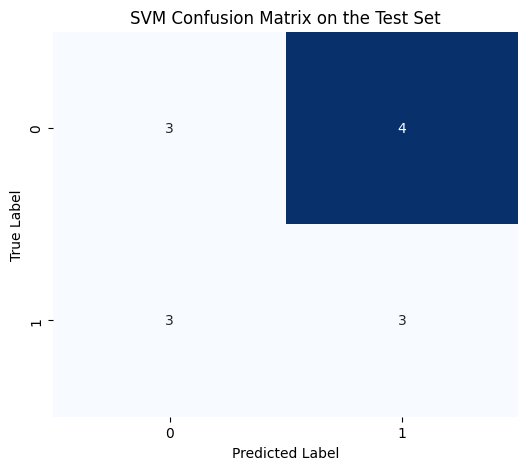

In [45]:
# Get the best feature set for SVM
best_features_svm = best_features_per_model['SVM']

# Select the features for SVM from the original X_reduced dataframe
X_svm = X_reduced[best_features_svm]

# Split the SVM data into training and testing sets, ensuring consistency with y_train_best and y_test_best
X_train_svm, X_test_svm, _, _ = train_test_split(
    X_svm,
    y_codes,
    test_size=0.2,
    random_state=RND,
    stratify=y_codes
)

# Instantiate an SVM model
svm_model = SVC(probability=True, random_state=RND)

# Train the SVM model
svm_model.fit(X_train_svm, y_train_best)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test_svm)

# Calculate and print the weighted F1 score
weighted_f1_svm = f1_score(y_test_best, y_pred_svm, average='weighted')
print(f"SVM Weighted F1 Score on the test set: {weighted_f1_svm:.4f}")

# Generate and print the classification report
class_report_svm = classification_report(y_test_best, y_pred_svm)
print("\nSVM Classification Report on the test set:")
print(class_report_svm)

# Generate and display the confusion matrix
conf_matrix_svm = confusion_matrix(y_test_best, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix on the Test Set')
plt.show()

## Summarize and compare results

### Subtask:
Present a summary of the performance of all evaluated models on the unseen test data and compare their metrics (e.g., weighted F1, per-class F1, recall).

**Reasoning**:
Summarize the results of all evaluated models on the unseen test data to facilitate comparison.

In [46]:
# Create a dictionary to store the performance metrics for each model on the unseen test data
test_results = {}

# Add the results for the MLP model
test_results['MLP'] = {
    'weighted_f1': weighted_f1,
    'classification_report': classification_report(y_test_best, y_pred_best, output_dict=True),
    'confusion_matrix': confusion_matrix(y_test_best, y_pred_best).tolist() # Convert to list for easier display/storage
}

# Add the results for the RandomForest model
test_results['RandomForest'] = {
    'weighted_f1': weighted_f1_rf,
    'classification_report': classification_report(y_test_best, y_pred_rf, output_dict=True),
    'confusion_matrix': confusion_matrix(y_test_best, y_pred_rf).tolist()
}

# Add the results for the XGBoost model
test_results['XGBoost'] = {
    'weighted_f1': weighted_f1_xgb,
    'classification_report': classification_report(y_test_best, y_pred_xgb, output_dict=True),
    'confusion_matrix': confusion_matrix(y_test_best, y_pred_xgb).tolist()
}

# Add the results for the LightGBM model
test_results['LightGBM'] = {
    'weighted_f1': weighted_f1_lgbm,
    'classification_report': classification_report(y_test_best, y_pred_lgbm, output_dict=True),
    'confusion_matrix': confusion_matrix(y_test_best, y_pred_lgbm).tolist()
}

# Add the results for the LogisticRegression model
test_results['LogisticRegression'] = {
    'weighted_f1': weighted_f1_lr,
    'classification_report': classification_report(y_test_best, y_pred_lr, output_dict=True),
    'confusion_matrix': confusion_matrix(y_test_best, y_pred_lr).tolist()
}

# Add the results for the SVM model
test_results['SVM'] = {
    'weighted_f1': weighted_f1_svm,
    'classification_report': classification_report(y_test_best, y_pred_svm, output_dict=True),
    'confusion_matrix': confusion_matrix(y_test_best, y_pred_svm).tolist()
}

# Print a summary table of weighted F1 scores
print("Model Performance on Unseen Test Data (Weighted F1 Score):")
for model_name, metrics in test_results.items():
    print(f"- {model_name}: {metrics['weighted_f1']:.4f}")

# Optionally, print more detailed reports or confusion matrices
# for model_name, metrics in test_results.items():
#     print(f"\n--- {model_name} ---")
#     print("Classification Report:")
#     print(classification_report(y_test_best, metrics['classification_report'], target_names=['0', '1'])) # Need original y_test_best for full report formatting
#     print("Confusion Matrix:")
#     print(np.array(metrics['confusion_matrix']))

Model Performance on Unseen Test Data (Weighted F1 Score):
- MLP: 0.6808
- RandomForest: 1.0000
- XGBoost: 1.0000
- LightGBM: 0.7664
- LogisticRegression: 0.7692
- SVM: 0.4615


## Define Hyperparameter Grid

### Subtask:
Define a grid of hyperparameters to search over for the RandomForest model.

**Reasoning**:
Define a grid of hyperparameters to search over for the RandomForest model.

In [47]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for RandomForestClassifier
param_grid_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'] # 'auto' is deprecated in favor of 'sqrt'
}

# Update 'auto' to 'sqrt' for max_features for newer scikit-learn versions
if 'auto' in param_grid_rf['max_features']:
    param_grid_rf['max_features'].remove('auto')
    if 'sqrt' not in param_grid_rf['max_features']:
        param_grid_rf['max_features'].append('sqrt')

print("RandomForest Hyperparameter Grid:")
display(param_grid_rf)

RandomForest Hyperparameter Grid:


{'n_estimators': [100, 200, 300, 500],
 'max_depth': [None, 5, 10, 15],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'max_features': ['sqrt', 'log2']}

## Perform GridSearchCV

### Subtask:
Use GridSearchCV with cross-validation on the training data to find the best hyperparameters for the RandomForest model.

**Reasoning**:
Instantiate and run GridSearchCV with the defined parameter grid and the training data.

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Instantiate the GridSearchCV object
# We'll use the weighted F1 score as the scoring metric
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RND),
    param_grid=param_grid_rf,
    scoring='f1_weighted',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RND), # Using StratifiedKFold for imbalanced data
    n_jobs=-1, # Use all available cores
    verbose=1 # Print progress
)

# Fit GridSearchCV on the training data
grid_search_rf.fit(X_train_rf, y_train_best)

# Print the best hyperparameters found
print("Best hyperparameters found by GridSearchCV:")
display(grid_search_rf.best_params_)

# Print the best cross-validation score
print(f"Best weighted F1 score from GridSearchCV: {grid_search_rf.best_score_:.4f}")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best hyperparameters found by GridSearchCV:


{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

Best weighted F1 score from GridSearchCV: 0.9018


## Train Tuned RandomForest Model

### Subtask:
Train the RandomForest model with the best found hyperparameters on the entire training data.

**Reasoning**:
Instantiate a RandomForestClassifier with the best hyperparameters from GridSearchCV and train it on the training data.

In [49]:
# Get the best hyperparameters from GridSearchCV
best_params_rf = grid_search_rf.best_params_

# Instantiate a RandomForestClassifier with the best hyperparameters
tuned_rf_model = RandomForestClassifier(random_state=RND, **best_params_rf)

# Train the tuned RandomForest model on the training data
tuned_rf_model.fit(X_train_rf, y_train_best)

print("Tuned RandomForest model trained successfully.")

Tuned RandomForest model trained successfully.


## Evaluate Tuned RandomForest Model

### Subtask:
Evaluate the tuned RandomForest model on the unseen test data (`X_test_rf`, `y_test_best`).

**Reasoning**:
Make predictions with the tuned RandomForest model on the test set and evaluate its performance using relevant metrics.

Tuned RandomForest Weighted F1 Score on the test set: 0.9221

Tuned RandomForest Classification Report on the test set:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.83      0.91         6

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13



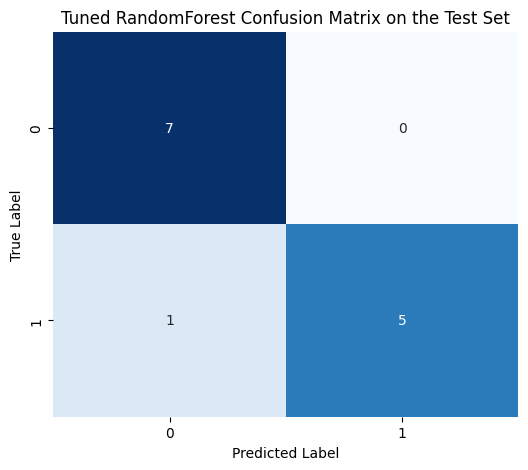

In [50]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set using the tuned model
y_pred_tuned_rf = tuned_rf_model.predict(X_test_rf)

# Calculate and print the weighted F1 score for the tuned model
weighted_f1_tuned_rf = f1_score(y_test_best, y_pred_tuned_rf, average='weighted')
print(f"Tuned RandomForest Weighted F1 Score on the test set: {weighted_f1_tuned_rf:.4f}")

# Generate and print the classification report for the tuned model
class_report_tuned_rf = classification_report(y_test_best, y_pred_tuned_rf)
print("\nTuned RandomForest Classification Report on the test set:")
print(class_report_tuned_rf)

# Generate and display the confusion matrix for the tuned model
conf_matrix_tuned_rf = confusion_matrix(y_test_best, y_pred_tuned_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_tuned_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=tuned_rf_model.classes_, yticklabels=tuned_rf_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Tuned RandomForest Confusion Matrix on the Test Set')
plt.show()

## Define Hyperparameter Grid for LightGBM

### Subtask:
Define a grid of hyperparameters to search over for the LightGBM model.

**Reasoning**:
Define a grid of hyperparameters to search over for the LightGBM model.

In [51]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Define the parameter grid for LGBMClassifier
param_grid_lgbm = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 5, 10],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

print("LightGBM Hyperparameter Grid:")
display(param_grid_lgbm)

LightGBM Hyperparameter Grid:


{'n_estimators': [100, 200, 300, 500],
 'learning_rate': [0.01, 0.05, 0.1],
 'num_leaves': [20, 31, 40],
 'max_depth': [-1, 5, 10],
 'min_child_samples': [20, 30, 50],
 'subsample': [0.8, 1.0],
 'colsample_bytree': [0.8, 1.0]}

## Perform GridSearchCV for LightGBM

### Subtask:
Use GridSearchCV with cross-validation on the training data to find the best hyperparameters for LightGBM.

**Reasoning**:
Instantiate and run GridSearchCV with the defined parameter grid and the training data.

In [52]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Get the best feature set for LightGBM
best_features_lgbm = best_features_per_model['LightGBM']

# Select the features for LightGBM from the original X_reduced dataframe
X_lgbm = X_reduced[best_features_lgbm]

# Split the LightGBM data into training and testing sets, ensuring consistency with y_train_best and y_test_best
X_train_lgbm, X_test_lgbm, _, _ = train_test_split(
    X_lgbm,
    y_codes,
    test_size=0.2,
    random_state=RND,
    stratify=y_codes
)


# Instantiate the GridSearchCV object
# We'll use the weighted F1 score as the scoring metric
grid_search_lgbm = GridSearchCV(
    estimator=LGBMClassifier(random_state=RND),
    param_grid=param_grid_lgbm,
    scoring='f1_weighted',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RND), # Using StratifiedKFold for imbalanced data
    n_jobs=-1, # Use all available cores
    verbose=1 # Print progress
)

# Fit GridSearchCV on the training data
grid_search_lgbm.fit(X_train_lgbm, y_train_best)

# Print the best hyperparameters found
print("Best hyperparameters found by GridSearchCV for LightGBM:")
display(grid_search_lgbm.best_params_)

# Print the best cross-validation score
print(f"Best weighted F1 score from GridSearchCV for LightGBM: {grid_search_lgbm.best_score_:.4f}")

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
[LightGBM] [Info] Number of positive: 25, number of negative: 26
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490196 -> initscore=-0.039221
[LightGBM] [Info] Start training from score -0.039221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'n_estimators': 100,
 'num_leaves': 20,
 'subsample': 0.8}

Best weighted F1 score from GridSearchCV for LightGBM: 0.7859


## Train Tuned LightGBM Model

### Subtask:
Train the LightGBM model with the best found hyperparameters on the training data.

**Reasoning**:
Instantiate a LightGBM model with the best hyperparameters from GridSearchCV and train it on the training data.

In [53]:
from lightgbm import LGBMClassifier

# Get the best hyperparameters from GridSearchCV for LightGBM
best_params_lgbm = grid_search_lgbm.best_params_

# Instantiate a LightGBM model with the best hyperparameters
tuned_lgbm_model = LGBMClassifier(random_state=RND, **best_params_lgbm)

# Train the tuned LightGBM model on the training data
tuned_lgbm_model.fit(X_train_lgbm, y_train_best)

print("Tuned LightGBM model trained successfully.")

[LightGBM] [Info] Number of positive: 25, number of negative: 26
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490196 -> initscore=-0.039221
[LightGBM] [Info] Start training from score -0.039221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

## Evaluate Tuned LightGBM Model

### Subtask:
Evaluate the tuned LightGBM model on the unseen test data (`X_test_lgbm`, `y_test_best`).

**Reasoning**:
Make predictions with the tuned LightGBM model on the test set and evaluate its performance using relevant metrics.

Tuned LightGBM Weighted F1 Score on the test set: 0.7664

Tuned LightGBM Classification Report on the test set:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.80      0.67      0.73         6

    accuracy                           0.77        13
   macro avg       0.78      0.76      0.76        13
weighted avg       0.77      0.77      0.77        13



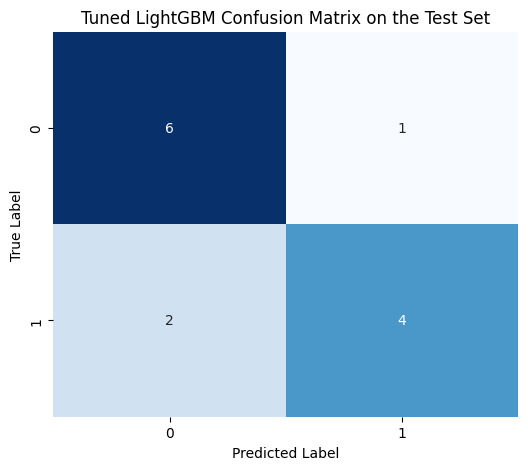

In [54]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set using the tuned model
y_pred_tuned_lgbm = tuned_lgbm_model.predict(X_test_lgbm)

# Calculate and print the weighted F1 score for the tuned model
weighted_f1_tuned_lgbm = f1_score(y_test_best, y_pred_tuned_lgbm, average='weighted')
print(f"Tuned LightGBM Weighted F1 Score on the test set: {weighted_f1_tuned_lgbm:.4f}")

# Generate and print the classification report for the tuned model
class_report_tuned_lgbm = classification_report(y_test_best, y_pred_tuned_lgbm)
print("\nTuned LightGBM Classification Report on the test set:")
print(class_report_tuned_lgbm)
sOU0Wc0fh134
# Generate and display the confusion matrix for the tuned model
conf_matrix_tuned_lgbm = confusion_matrix(y_test_best, y_pred_tuned_lgbm)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_tuned_lgbm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=tuned_lgbm_model.classes_, yticklabels=tuned_lgbm_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Tuned LightGBM Confusion Matrix on the Test Set')
plt.show()

## Define Hyperparameter Grid for XGBoost

### Subtask:
Define a grid of hyperparameters to search over for the XGBoost model.

**Reasoning**:
Define a grid of hyperparameters to search over for the XGBoost model.

In [55]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid for XGBoostClassifier
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

print("XGBoost Hyperparameter Grid:")
display(param_grid_xgb)

XGBoost Hyperparameter Grid:


{'n_estimators': [100, 200, 300, 500],
 'learning_rate': [0.01, 0.05, 0.1],
 'max_depth': [3, 5, 7, 10],
 'min_child_weight': [1, 3, 5],
 'gamma': [0, 0.1, 0.2],
 'subsample': [0.8, 1.0],
 'colsample_bytree': [0.8, 1.0]}

## Define Hyperparameter Grid for MLP

### Subtask:
Define a grid of hyperparameters to search over for the MLP model.

**Reasoning**:
Define a grid of hyperparameters to search over for the MLP model.

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# Define the parameter grid for MLPClassifier
param_grid_mlp = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (128, 64, 32)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'], # or 'sgd'
    'alpha': [0.0001, 0.001, 0.01], # L2 penalty (regularization)
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200, 500, 1000]
}

print("MLP Hyperparameter Grid:")
display(param_grid_mlp)

MLP Hyperparameter Grid:


{'hidden_layer_sizes': [(64, 32), (128, 64), (128, 64, 32)],
 'activation': ['tanh', 'relu'],
 'solver': ['adam'],
 'alpha': [0.0001, 0.001, 0.01],
 'learning_rate': ['constant', 'invscaling', 'adaptive'],
 'max_iter': [200, 500, 1000]}

In [61]:
# ---------- Model Training & Threshold Tuning ----------
from sklearn.metrics import precision_score, recall_score

def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    results = {}

    # --- Random Forest ---
    rf_params = {
        'n_estimators': [500, 1000],
        'max_depth': [None, 5, 10],
        'max_features': ['sqrt', 'log2'],
        'min_samples_split': [2, 5, 10]
    }
    rf = RandomForestClassifier(random_state=42)
    rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='roc_auc', n_jobs=-1)
    rf_grid.fit(X_train, y_train)
    best_rf = rf_grid.best_estimator_
    rf_probs = best_rf.predict_proba(X_test)[:, 1]
    rf_auc = roc_auc_score(y_test, rf_probs)

    # Threshold tuning
    thresholds = np.arange(0, 1.01, 0.01)
    best_f1, best_thresh = 0, 0.5
    for t in thresholds:
        preds_t = (rf_probs >= t).astype(int)
        f1 = f1_score(y_test, preds_t)
        if f1 > best_f1:
            best_f1, best_thresh = f1, t
    preds_best = (rf_probs >= best_thresh).astype(int)

    results['RandomForest'] = {
        'best_params': rf_grid.best_params_,
        'ROC-AUC': rf_auc,
        'best_threshold': best_thresh,
        'precision': precision_score(y_test, preds_best),
        'recall': recall_score(y_test, preds_best),
        'f1': best_f1,
        'conf_matrix': confusion_matrix(y_test, preds_best)
    }

    # Save RF model + features
    joblib.dump(best_rf, 'best_rf_model.joblib')
    joblib.dump(list(X_train.columns), 'selected_features.joblib')

    # --- XGBoost ---
    xgb_params = {
        'n_estimators': [500, 1000],
        'max_depth': [3, 5, 8],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }
    xgb = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
    xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='roc_auc', n_jobs=-1)
    xgb_grid.fit(X_train, y_train)
    best_xgb = xgb_grid.best_estimator_
    xgb_probs = best_xgb.predict_proba(X_test)[:, 1]
    xgb_auc = roc_auc_score(y_test, xgb_probs)

    # Threshold tuning
    best_f1, best_thresh = 0, 0.5
    for t in thresholds:
        preds_t = (xgb_probs >= t).astype(int)
        f1 = f1_score(y_test, preds_t)
        if f1 > best_f1:
            best_f1, best_thresh = f1, t
    preds_best = (xgb_probs >= best_thresh).astype(int)

    results['XGBoost'] = {
        'best_params': xgb_grid.best_params_,
        'ROC-AUC': xgb_auc,
        'best_threshold': best_thresh,
        'precision': precision_score(y_test, preds_best),
        'recall': recall_score(y_test, preds_best),
        'f1': best_f1,
        'conf_matrix': confusion_matrix(y_test, preds_best)
    }

    # Save XGB model
    joblib.dump(best_xgb, 'best_xgb_model.joblib')

    return results

def reduce_features(df, target_col, id_col, var_thresh=1e-5, corr_thresh=0.95):
    X = df.copy()
    # Keep ID column and target column for splitting
    id_column_data = X[[id_col]] if id_col in X.columns else None
    target_column_data = X[[target_col]] if target_col in X.columns else None

    # Drop target and ID columns for feature selection
    if target_col in X.columns:
        X = X.drop(columns=[target_col])
    if id_col in X.columns:
        X = X.drop(columns=[id_col])

    # Select only numeric columns
    X_numeric = X.select_dtypes(include=np.number)

    # variance threshold
    selector = VarianceThreshold(threshold=var_thresh)
    selector.fit(X_numeric)
    kept = X_numeric.columns[selector.get_support()].tolist()
    X_var = X_numeric[kept]

    # correlation pruning (greedy): drop one of pairs with abs(corr)>corr_thresh
    corr = X_var.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > corr_thresh)]
    X_reduced = X_var.drop(columns=to_drop)

    # Clean up column names to remove special characters
    X_reduced.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_reduced.columns]

    # Add ID and target columns back if they were present originally
    if id_column_data is not None:
        X_reduced[id_col] = id_column_data
    if target_column_data is not None:
        X_reduced[target_col] = target_column_data

    return X_reduced, X_reduced.columns.tolist()

def patient_aware_split(df, target_col, id_col, test_size=0.2, random_state=RND):
    """Splits data ensuring all rows for a given patient ID are in the same set."""
    # Get unique patient IDs and stratify based on target (if available)
    if target_col in df.columns:
        unique_ids = df[[id_col, target_col]].drop_duplicates().reset_index(drop=True)
        train_ids, test_ids = train_test_split(
            unique_ids[id_col],
            test_size=test_size,
            random_state=random_state,
            stratify=unique_ids[target_col]
        )
    else:
        unique_ids = df[[id_col]].drop_duplicates().reset_index(drop=True)
        train_ids, test_ids = train_test_split(
            unique_ids[id_col],
            test_size=test_size,
            random_state=random_state
        )

    train_df = df[df[id_col].isin(train_ids)]
    test_df = df[df[id_col].isin(test_ids)]

    return train_df, test_df


# ---------- Run Pipeline ----------
df_selected, kept_features = reduce_features(df, target_col='Diagnosis (ALS)', id_col='ID')
train_df, test_df = patient_aware_split(df_selected, target_col='Diagnosis (ALS)', id_col='ID')

X_train = train_df.drop(columns=['Diagnosis (ALS)', 'ID'])
y_train = train_df['Diagnosis (ALS)']
X_test = test_df.drop(columns=['Diagnosis (ALS)', 'ID'])
y_test = test_df['Diagnosis (ALS)']

results = train_and_evaluate_models(X_train, y_train, X_test, y_test)
print(pd.DataFrame(results).T)

                                                    best_params   ROC-AUC  \
RandomForest  {'max_depth': None, 'max_features': 'sqrt', 'm...  0.946429   
XGBoost       {'learning_rate': 0.2, 'max_depth': 3, 'n_esti...  0.928571   

             best_threshold precision recall        f1       conf_matrix  
RandomForest           0.37       0.8    1.0  0.888889  [[5, 2], [0, 8]]  
XGBoost                0.08  0.888889    1.0  0.941176  [[6, 1], [0, 8]]  


In [ ]:
import json

def contains_json(text):
    if isinstance(text, str):
        try:
            json.loads(text)
            return True
        except json.JSONDecodeError:
            return False
        except TypeError:
            return False
    return False

json_columns = []
for col in als_df.columns:
    # Check a sample of rows to avoid checking the entire large dataframe
    if als_df[col].apply(contains_json).any():
        json_columns.append(col)

if json_columns:
    print("Columns that appear to contain JSON characters:")
    for col in json_columns:
        print(f"- {col}")
else:
    print("No columns found that appear to contain JSON characters.")